In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
%matplotlib inline

In [97]:
# settings
LEARNING_RATE = 0.0004
TRAINING_ITERATIONS = 2500    
DROPOUT = 0.2
BATCH_SIZE = 100

# Demo/test image
IMAGE_TO_DISPLAY = 10

In [98]:
# read training data from CSV file 
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('train shape = {}'.format(data.shape))
print('test shape = {}'.format(test.shape))


train shape = (42000, 785)
test shape = (28000, 784)


labels number : 10


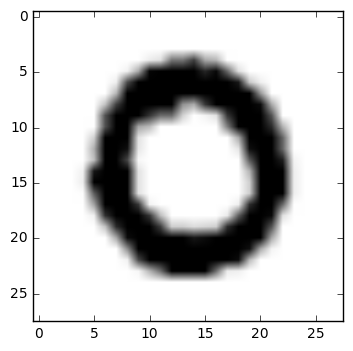

In [99]:
images = data.iloc[:,1:].values
images = images.astype(float)
images = np.multiply(images,1/255)
label = data['label'].values.ravel()
NumLabels = np.unique(label).shape[0]
print('labels number : {}'.format(NumLabels))

width = 28 
height = 28

# display image
def display(img):    
    # (784) => (28,28)
    one_image = img.reshape(width,height)
    plt.imshow(one_image, cmap=cm.binary)

# output image     
display(images[1])

In [100]:
# convert class labels from scalars to one-hot vectors
def dense_to_one_hot(label, num_classes):
    num_labels = label.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + label.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(label, NumLabels)
labels = labels.astype(np.uint8)
print(labels)

[[0 1 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 1 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 1]]


In [101]:
# split data into training & validation

x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.20, random_state=33)

print (x_train.shape, y_train.shape)
print (x_val.shape, y_val.shape)



(33600, 784) (33600, 10)
(8400, 784) (8400, 10)


'\nvalidation_images = images[:VALIDATION_SIZE]\nvalidation_labels = labels[:VALIDATION_SIZE]\n\ntrain_images = images[VALIDATION_SIZE:]\ntrain_labels = labels[VALIDATION_SIZE:]\n\n'

In [102]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def compute_accuracy(x_train, y_train):
    global prediction
    y_pre = sess.run(prediction, feed_dict={x: x_train, keep_prob: 1})
    correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(y_train,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    result = sess.run(accuracy, feed_dict={x: x_train, ys: y, y_train: 1})
    return result


In [103]:
# define placeholder for inputs to network

x = tf.placeholder('float32', shape=[None, 784])
y = tf.placeholder('float32', shape=[None, NumLabels])
keep_prob = tf.placeholder(tf.float32)
x_image = tf.reshape(x, [-1, 28, 28, 1])

## conv1 layer ##
W_conv1 = weight_variable([5,5, 1,32]) # patch 5x5, in size 1, out size 32
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) 
h_pool1 = max_pool_2x2(h_conv1)               

## conv2 layer ##
W_conv2 = weight_variable([5,5, 32, 64]) # patch 5x5, in size 32, out size 64
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) 
h_pool2 = max_pool_2x2(h_conv2)                           # output size 7x7x64


## fc1 layer ##
# densely connected layer
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])

# [n_samples, 7, 7, 64] ->> [n_samples, 7*7*64]
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
#=> (40000, 1024)

## fc2 layer ##
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_pred = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

# evaluation#loss function
cross_entropy = -tf.reduce_sum(y*tf.log(y_pred))
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))






In [104]:
epochs_completed = 0
index_in_epoch = 0
num_examples = x_train.shape[0]
print(num_examples)

# serve data by batches
def next_batch(batch_size):
    
    global x_train
    global y_train
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        x_train = x_train[perm]
        y_train = y_train[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return x_train[start:end], y_train[start:end]

33600


In [105]:
# start TensorFlow session
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()

sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [106]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

for i in range(TRAINING_ITERATIONS):

    #get new batch
    batch_x, batch_y = next_batch(BATCH_SIZE)        

    # print the training accuracy and validation accuracy
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, 
                                                  y: batch_y, 
                                                  keep_prob: 1.0})       
       
        validation_accuracy = accuracy.eval(feed_dict={ x: x_val[0:BATCH_SIZE], 
                                                            y: y_val[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})               
        
        trainLoss = sess.run([cross_entropy], feed_dict = {
                x: batch_x,
                y: batch_y,
                keep_prob: 1.0 })
        trainLoss = float(trainLoss[0])
                
        print('training accuracy / validation accuracy => %.4f / %.4f for training Loss %.4f with step %d'%(train_accuracy, validation_accuracy,trainLoss, i))          
        validation_accuracies.append(validation_accuracy)
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT})

training accuracy / validation accuracy => 0.1200 / 0.0900 for training Loss 773.6810 with step 0
training accuracy / validation accuracy => 0.1000 / 0.1200 for training Loss 412.8199 with step 1
training accuracy / validation accuracy => 0.1700 / 0.1400 for training Loss 324.1046 with step 2
training accuracy / validation accuracy => 0.2200 / 0.2600 for training Loss 333.4185 with step 3
training accuracy / validation accuracy => 0.3900 / 0.2800 for training Loss 273.1588 with step 4
training accuracy / validation accuracy => 0.2900 / 0.3500 for training Loss 271.2504 with step 5
training accuracy / validation accuracy => 0.3700 / 0.4100 for training Loss 245.3569 with step 6
training accuracy / validation accuracy => 0.5700 / 0.4500 for training Loss 154.9274 with step 7
training accuracy / validation accuracy => 0.4900 / 0.4700 for training Loss 150.2830 with step 8
training accuracy / validation accuracy => 0.5500 / 0.5200 for training Loss 124.5091 with step 9
training accuracy / 

validation_accuracy => 0.9945
train_accuracy_accuracy => 0.9900


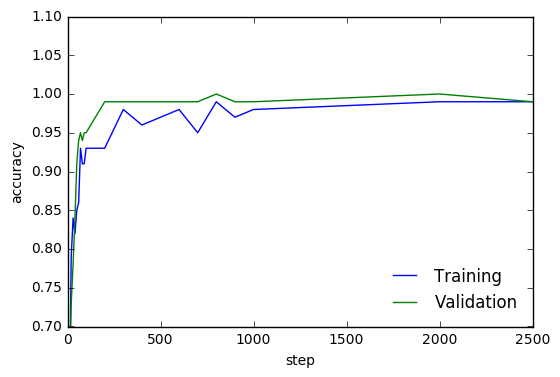

In [109]:
validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                               y: validation_labels, 
                                               keep_prob: 1.0})
print('validation_accuracy => %.4f'%validation_accuracy)
print('train_accuracy_accuracy => %.4f'%train_accuracy)
plt.plot(x_range, train_accuracies,'-b', label='Training')
plt.plot(x_range, validation_accuracies,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 1.1, ymin = 0.7)
plt.ylabel('accuracy')
plt.xlabel('step')
plt.show()

test_images(28000,784)
predicted_lables(28000)
predicted_lables[10] => 5.0


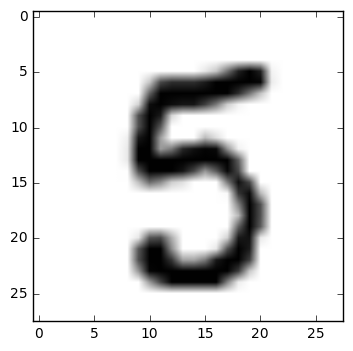

In [110]:
test_images = test.values.astype('float32')
test_images = np.multiply(test_images, 1.0 / 255.0)
predict = tf.argmax(y_pred,1)

print('test_images({0[0]},{0[1]})'.format(test_images.shape))


# predict test set
predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE:(i+1)*BATCH_SIZE], keep_prob: 1.0})    

print('predicted_lables({0})'.format(len(predicted_lables)))

# output test image and prediction
display(test_images[IMAGE_TO_DISPLAY])
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_lables[IMAGE_TO_DISPLAY]))

# save results
np.savetxt('cnn_2layer.csv', 
           np.c_[range(1,len(test_images)+1),predicted_lables], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')